In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import time
from functools import reduce

sys.path.append("../gaia_tools/")
import data_analysis
import transformation_constants
import covariance_generation
from import_functions import import_data

In [2]:
path = "/hdfs/local/sven/gaia_tools_data/gaia_rv_data_bayes.csv"
data_icrs = import_data(path = path, debug = False)

Start import...
The dimensions of the data: (rows, columns) -> (7133471, 24)
Checking indexing... 



In [3]:
# Transform coordinates
galcen_data = data_analysis.get_transformed_data(data_icrs,
                                        include_cylindrical = True,
                                        debug = True,
                                        is_bayes = True, 
                                        is_source_included = True)

# Generate covariance information
cov_df = covariance_generation.generate_covmatrices(df = data_icrs, 
                                        df_crt = galcen_data, 
                                        transform_to_galcen = True, 
                                        transform_to_cylindrical = True,
                                        is_bayes = True,
                                        debug=True)

galcen_data['cov_mat'] = cov_df['cov_mat']

# galcen_data = galcen_data[(galcen_data.r < 12000) & (galcen_data.r > 5000) ]
# galcen_data.reset_index(inplace=True, drop=True)

Starting galactocentric transformation loop over all data points.. 
Time elapsed for data coordinate transformation: 32.40166992228478 sec
Generating covariance matrices from input data..
Time elapsed for covariance matrix generation and transformation: 67.36846323125064 sec


In [5]:
min_val = np.min(galcen_data.r)
max_val = np.max(galcen_data.r)

# Default bins in range: -10 - 10 [kpc]
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                theta = (0, 0),
                                                BL_r_min = min_val - 1, 
                                                BL_r_max = max_val + 1, 
                                                BL_z_min = -1200, 
                                                BL_z_max = 1200, 
                                                N_bins = (10, 4),
                                                r_drift = False, 
                                                debug = True)

Binning data from galactocentric input data...
Max r value in DataFrame 26818.705945543847
Time elapsed for binning data with collapsed bins: 3.082871316932142 sec


In [18]:
test_bin = bin_collection.bins[1]
print(test_bin.z_boundaries)
print(test_bin.data.columns)

(-600.0, 0.0)
Index(['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'r', 'phi', 'v_r', 'v_phi',
       'source_id', 'cov_mat', 'Bin_index'],
      dtype='object')


In [184]:
def plot_velocity_distribution(bins):

    if(len(bins) % np.sqrt(len(bins)) == 0):
        figs_x = round(np.sqrt(len(bins)))
        figs_y = figs_x
    else:
        figs_x = round(np.sqrt(len(bins)))
        figs_y = figs_x+1

    if(len(bins) > 5):
        figsize = 15
    else:
        figsize = 10

    fig, axs = plt.subplots(figs_y, figs_x, figsize = (figsize,figsize))

    for i, ax in enumerate(axs.flat):

        if(i < len(bins)):

            if(np.abs(np.min(bins[i].data.v_phi) - np.max(bins[i].data.v_phi)) > 500):
                n_bins = 80
            else:
                n_bins = 40

            z_range = bins[i].z_boundaries
            r_range = bins[i].r_boundaries

            text_string = "$z \in [{:.1f}, {:.1f}]$\n$r \in [{:.1f}, {:.1f}]$".format(z_range[0], z_range[1], 
                                                                                    r_range[0], r_range[1])
            ax.text(0.75, 0.8,text_string, horizontalalignment='center',
                                            verticalalignment='center',
                                            transform = ax.transAxes, fontdict={'fontsize': 12})

            label_string = "$z - {}\nr -{}$".format(z_range, r_range)

            ax.hist(bins[i].data.v_phi, bins=n_bins, edgecolor='black', label=label_string)
            ax.set_xlabel("$v_\phi$", fontdict={'fontsize': 15}, labelpad = 5)
            
            ax.set_ylabel("N", fontdict={'fontsize': 15}, labelpad = 10, rotation=0)
            ax.ticklabel_format(axis="y", style="sci", scilimits=(3,3))
            ax.yaxis.set_label_coords(-0.1, 1.0)

            #ax.axvline(x=0, ls="--", label="Max", color='r')
        
        else:
            fig.delaxes(ax)

    plt.tight_layout()
    #fig.suptitle("Velocity distribution in r-z bins", fontsize=18)


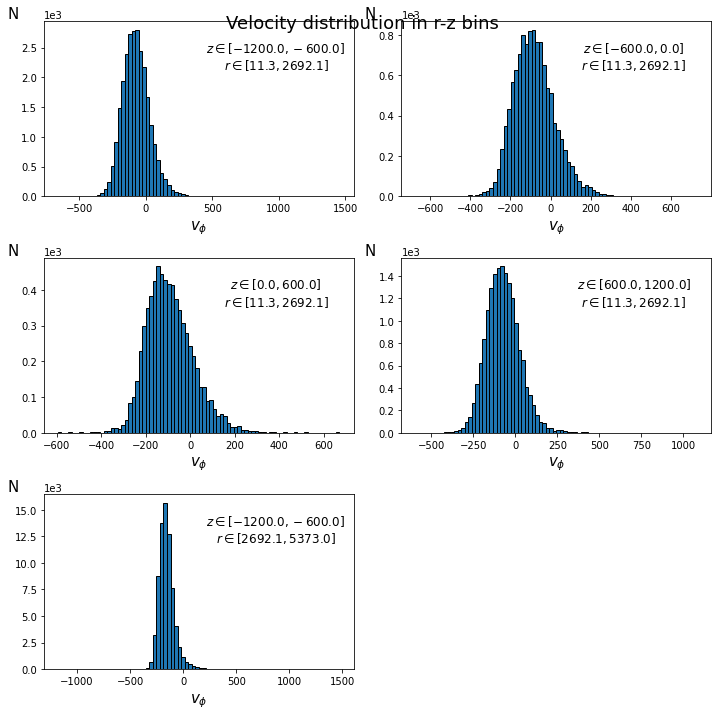

In [185]:
plot_velocity_distribution(bin_collection.bins[0:5])

In [141]:
# Default bins in range: -10 - 10 [kpc]
bin_collection_thin = data_analysis.get_collapsed_bins(data = galcen_data,
                                                theta = (0, 0),
                                                BL_r_min = min_val - 1, 
                                                BL_r_max = max_val + 1, 
                                                BL_z_min = -200, 
                                                BL_z_max = 200, 
                                                N_bins = (10, 4),
                                                r_drift = False, 
                                                debug = True)

Binning data from galactocentric input data...
Max r value in DataFrame 26818.705945543847
Time elapsed for binning data with collapsed bins: 2.4716362906619906 sec


In [156]:
num_bins = len(bin_collection_thin.bins[0:10])

round(np.sqrt(num_bins))

3

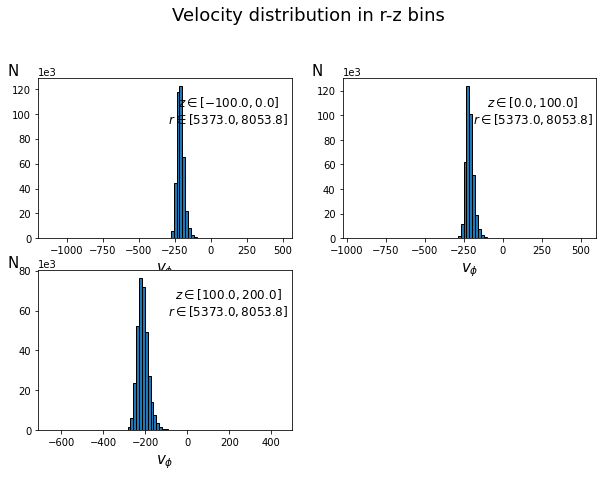

In [183]:

plot_velocity_distribution(bin_collection_thin.bins[9:12])